In [1]:
USE_FULL_TRAINED = True
FILE_NAME = "full_GENEI.csv" if USE_FULL_TRAINED else "tree_predictions_full.csv"
COLUMN_NAME = 'risk_group' if USE_FULL_TRAINED else 'Tree_group'

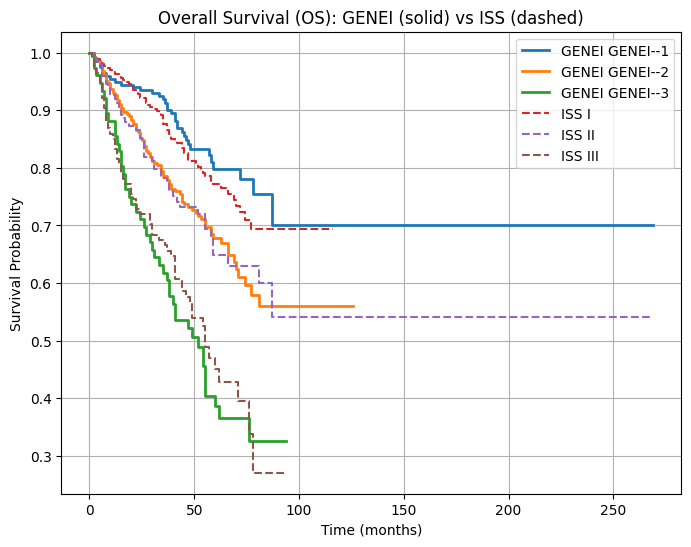

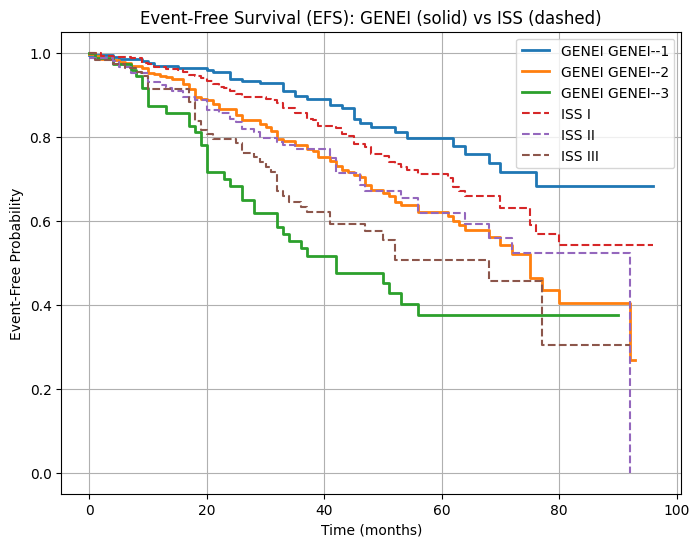

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# === Load your data ===
df = pd.read_csv(FILE_NAME)

# Fix type issues
df = df.dropna(subset=['ISS Staging'])
df[COLUMN_NAME] = df[COLUMN_NAME].astype(str)

kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))

for g in sorted(df[COLUMN_NAME].unique()):
    sub = df[df[COLUMN_NAME] == g]
    kmf.fit(sub['OS_time'], sub['OS_event'], label=f"GENEI {g}")
    kmf.plot(ci_show=False, linestyle='-', lw=2)

for s in sorted(df['ISS Staging'].unique()):
    sub = df[df['ISS Staging'] == s]
    kmf.fit(sub['OS_time'], sub['OS_event'], label=f"ISS {s}")
    kmf.plot(ci_show=False, linestyle='--', lw=1.5)

plt.title("Overall Survival (OS): GENEI (solid) vs ISS (dashed)")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


# === OVERLAYED EFS ===
plt.figure(figsize=(8,6))

# Plot GENEI (solid)
for g in sorted(df[COLUMN_NAME].unique()):
    sub = df[df[COLUMN_NAME] == g]
    kmf.fit(sub['EFS_time'], sub['EFS_event'], label=f"GENEI {g}")
    kmf.plot(ci_show=False, linestyle='-', lw=2)

# Plot ISS (dashed)
for s in sorted(df['ISS Staging'].unique()):
    sub = df[df['ISS Staging'] == s]
    kmf.fit(sub['EFS_time'], sub['EFS_event'], label=f"ISS {s}")
    kmf.plot(ci_show=False, linestyle='--', lw=1.5)

plt.title("Event-Free Survival (EFS): GENEI (solid) vs ISS (dashed)")
plt.xlabel("Time (months)")
plt.ylabel("Event-Free Probability")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
from lifelines import CoxPHFitter

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['ISS Staging', COLUMN_NAME], drop_first=True)

# Fit Cox model for OS
cph = CoxPHFitter()
cph.fit(df_encoded, duration_col='OS_time', event_col='OS_event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 558 total observations, 386 right-censored observations>
             duration col = 'OS_time'
                event col = 'OS_event'
      baseline estimation = breslow
   number of observations = 558
number of events observed = 172
   partial log-likelihood = -790.96
         time fit was run = 2025-11-05 06:12:31 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Patient_ID          -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
EPAS1                0.04      1.05      0.09           -0.12            0.21                0.89                1.24
ERC2                -0.07      0.93      0.05           -0.16            0.03                0.85                1.03
PRC1                 0.17      1.18      0.08            0.02            0.32                1.02                1.37
CSGALNACT1           0.09      1.10      0.08           -0.07            0.26                0.93                1.30
CCND1               -0.02      0.98      0.03           -0.08            0.04                0.93                1.04
risk_score           0.04      1.04      0.33           -0.61            0.69                0.54                2.00
EFS_event           -1.55      0.21      0.22           -1.98           -1.13                0.14                0.32
EFS_time            -0.09      0.91      0.01           -0.10           -0.08                0.90                0.92
ISS Staging_II       0.12      1.13      0.20           -0.28            0.52                0.76                1.67
ISS Staging_III      0.50      1.65      0.20            0.11            0.89                1.11                2.44
risk_group_GENEI--2  0.33      1.39      0.47           -0.60            1.26                0.55                3.52
risk_group_GENEI--3  0.86      2.36      0.88           -0.87            2.58                0.42               13.19

                     cmp to      z      p  -log2(p)
covariate                                          
Patient_ID             0.00  -4.91 <0.005     20.04
EPAS1                  0.00   0.53   0.60      0.74
ERC2                   0.00  -1.37   0.17      2.54
PRC1                   0.00   2.16   0.03      5.02
CSGALNACT1             0.00   1.12   0.26      1.93
CCND1                  0.00  -0.63   0.53      0.93
risk_score             0.00   0.12   0.91      0.14
EFS_event              0.00  -7.20 <0.005     40.58
EFS_time               0.00 -16.77 <0.005    207.19
ISS Staging_II         0.00   0.58   0.56      0.83
ISS Staging_III        0.00   2.50   0.01      6.34
risk_group_GENEI--2    0.00   0.69   0.49      1.04
risk_group_GENEI--3    0.00   0.97   0.33      1.60
---
Concordance = 0.94
Partial AIC = 1607.92
log-likelihood ratio test = 455.25 on 13 df
-log2(p) of ll-ratio test = 293.46

In [4]:
import pandas as pd
from lifelines import KaplanMeierFitter

# Load data
df = pd.read_csv(FILE_NAME)
df = df.dropna(subset=['ISS Staging'])
df['ISS Staging'] = df['ISS Staging'].astype(str)
df[COLUMN_NAME] = df[COLUMN_NAME].astype(str)

kmf = KaplanMeierFitter()

# --- Median survival for GENEI ---
print("\nGENEI groups:")
for g in sorted(df[COLUMN_NAME].unique()):
    sub = df[df[COLUMN_NAME] == g]
    kmf.fit(sub['OS_time'], sub['OS_event'], label=g, alpha=0.10)  # 90% CI
    median_ = kmf.median_survival_time_
    ci = kmf.confidence_interval_survival_function_.iloc[:, 0].quantile([0.05, 0.95])
    print(f"{g}: median={median_:.2f} months (approx 90% CI: {ci.iloc[0]:.1f}–{ci.iloc[1]:.1f})")

# --- Median survival for ISS ---
print("\nISS Stages:")
for s in sorted(df['ISS Staging'].unique()):
    sub = df[df['ISS Staging'] == s]
    kmf.fit(sub['OS_time'], sub['OS_event'], label=s, alpha=0.10)
    median_ = kmf.median_survival_time_
    ci = kmf.confidence_interval_survival_function_.iloc[:, 0].quantile([0.05, 0.95])
    print(f"{s}: median={median_:.2f} months (approx 90% CI: {ci.iloc[0]:.1f}–{ci.iloc[1]:.1f})")



GENEI groups:
GENEI--1: median=inf months (approx 90% CI: 0.6–0.9)
GENEI--2: median=inf months (approx 90% CI: 0.5–1.0)
GENEI--3: median=52.00 months (approx 90% CI: 0.2–0.9)

ISS Stages:
I: median=inf months (approx 90% CI: 0.6–1.0)
II: median=inf months (approx 90% CI: 0.4–0.9)
III: median=55.00 months (approx 90% CI: 0.1–0.9)



[ISS Staging | OS_time]  log-rank: chi2=41.799, p=8.38e-10


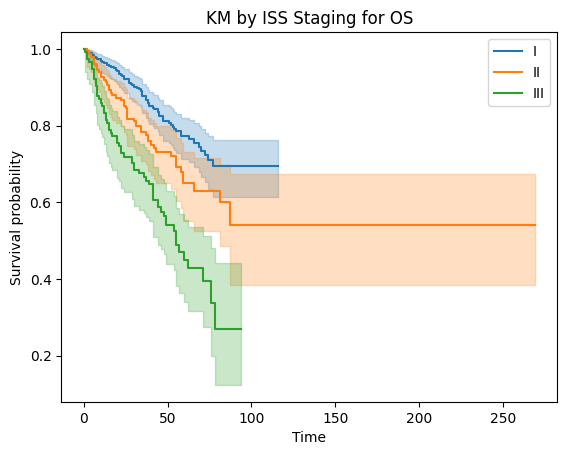


[ISS Staging | EFS_time]  log-rank: chi2=15.646, p=0.000401


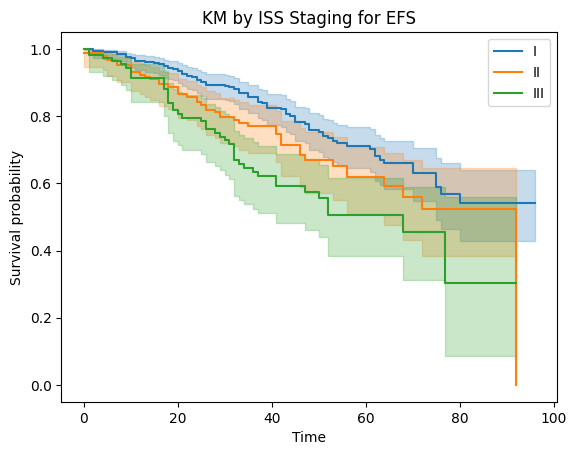


[risk_group | OS_time]  log-rank: chi2=46.965, p=6.33e-11


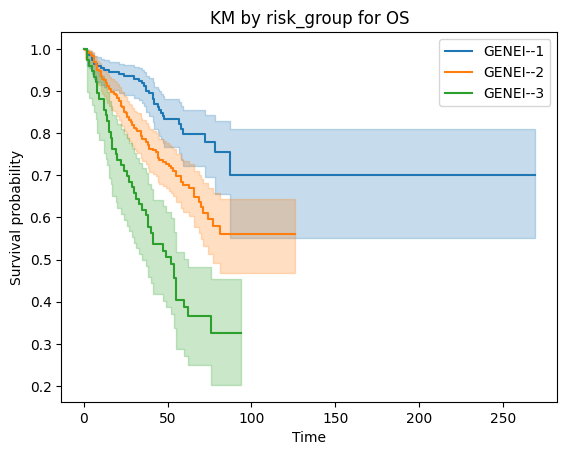


[risk_group | EFS_time]  log-rank: chi2=40.839, p=1.35e-09


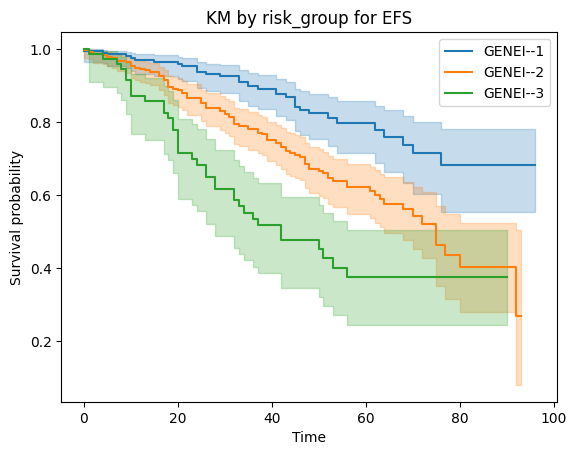

In [5]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

def km_logrank(df, time_col, event_col, group_col, title_suffix=""):
    # Log-rank test
    res = multivariate_logrank_test(
        event_durations=df[time_col],
        groups=df[group_col],
        event_observed=df[event_col]
    )
    print(f"\n[{group_col} | {time_col}]  log-rank: chi2={res.test_statistic:.3f}, p={res.p_value:.3g}")

    # Plot KM curves
    kmf = KaplanMeierFitter()
    plt.figure()
    for g, dfg in df.groupby(group_col):
        kmf.fit(durations=dfg[time_col], event_observed=dfg[event_col], label=str(g))
        kmf.plot(ci_show=True)
    plt.title(f"KM by {group_col} for {title_suffix or time_col}")
    plt.xlabel("Time")
    plt.ylabel("Survival probability")
    plt.show()

# Run for both models and both endpoints
for grp in ["ISS Staging", COLUMN_NAME]:
    km_logrank(df, "OS_time",  "OS_event",  grp, title_suffix="OS")
    km_logrank(df, "EFS_time", "EFS_event", grp, title_suffix="EFS")


In [6]:
from lifelines import CoxPHFitter

def cox_fit_info(df, time_col, event_col, group_col):
    # One-hot encode the group (drop first to avoid collinearity)
    X = pd.get_dummies(df[[group_col]], drop_first=True)
    X[time_col] = df[time_col].values
    X[event_col] = df[event_col].values

    cph = CoxPHFitter()
    cph.fit(X, duration_col=time_col, event_col=event_col)
    ll = cph.log_likelihood_
    try:
        aic = cph.AIC_partial_
    except AttributeError:
        # Fallback if lifelines version doesn't expose AIC; compute AIC = -2*LL + 2*k
        k = X.shape[1] - 2  # number of coefficients (dummies); minus time+event
        aic = -2*ll + 2*k

    print(f"[{group_col} | {time_col}]  logLik={ll:.3f}, AIC={aic:.3f}")
    # Optional: hazard ratios per category vs reference
    print(cph.summary[["exp(coef)", "p"]])
    return cph

cox_models = {}
for grp in ["ISS Staging", COLUMN_NAME]:
    cox_models[(grp, "OS")]  = cox_fit_info(df, "OS_time",  "OS_event",  grp)
    cox_models[(grp, "EFS")] = cox_fit_info(df, "EFS_time", "EFS_event", grp)


[ISS Staging | OS_time]  logLik=-1000.425, AIC=2004.850
                 exp(coef)             p
covariate                               
ISS Staging_II    1.608961  1.280636e-02
ISS Staging_III   3.053758  5.420159e-10
[ISS Staging | EFS_time]  logLik=-950.527, AIC=1905.055
                 exp(coef)         p
covariate                           
ISS Staging_II    1.412676  0.063451
ISS Staging_III   2.088875  0.000112
[risk_group | OS_time]  logLik=-998.031, AIC=2000.062
                     exp(coef)             p
covariate                                   
risk_group_GENEI--2   1.953699  7.639386e-04
risk_group_GENEI--3   4.244320  1.210814e-10
[risk_group | EFS_time]  logLik=-938.744, AIC=1881.487
                     exp(coef)             p
covariate                                   
risk_group_GENEI--2   2.178656  8.428333e-05
risk_group_GENEI--3   4.212635  1.179983e-09


In [7]:
from lifelines.utils import concordance_index

def cindex_from_cox(df, time_col, event_col, cph, group_col):
    # Build design matrix (same as training) to get risk scores
    X = pd.get_dummies(df[[group_col]], drop_first=True)
    risk = cph.predict_partial_hazard(X).values  # higher risk ⇒ shorter survival
    c = concordance_index(df[time_col].values, -risk, df[event_col].values)
    # Note: lifelines' concordance_index expects larger predicted values = longer survival,
    # hence we pass -risk.
    return c

for grp in ["ISS Staging", COLUMN_NAME]:
    c_os  = cindex_from_cox(df, "OS_time",  "OS_event",  cox_models[(grp, "OS")],  grp)
    c_efs = cindex_from_cox(df, "EFS_time", "EFS_event", cox_models[(grp, "EFS")], grp)
    print(f"[{grp}]  C-index OS={c_os:.3f} | EFS={c_efs:.3f}")


[ISS Staging]  C-index OS=0.622 | EFS=0.591
[risk_group]  C-index OS=0.629 | EFS=0.635


In [8]:
import numpy as np
from lifelines import CoxPHFitter

def cox_predicted_risk_at_T(df, time_col, event_col, group_col, T):
    # one-hot
    X = pd.get_dummies(df[[group_col]], drop_first=True)
    dat = pd.concat([X, df[[time_col, event_col]]], axis=1)

    cph = CoxPHFitter()
    cph.fit(dat, duration_col=time_col, event_col=event_col)

    # baseline survival and individual survival at T
    surv_at_T = cph.predict_survival_function(X, times=[T]).T.iloc[:, 0].values
    risk_at_T = 1.0 - surv_at_T  # cumulative incidence by T
    return risk_at_T

def nri_idi_at_T(df, time_col, event_col, T, riskA, riskB):
    # Observed status by T (1 if event occurred by T)
    status_T = ((df[event_col] == 1) & (df[time_col] <= T)).astype(int).values
    # Non-events by T: either censored after T or event after T (treated as 0 here)
    # (Note: this simplification ignores censoring bias)

    # Continuous NRI components
    events_idx = status_T == 1
    nonevents_idx = status_T == 0

    # For events: up = riskB > riskA; down = riskB < riskA
    p_up_events = np.mean((riskB[events_idx] > riskA[events_idx])) if events_idx.any() else np.nan
    p_down_events = np.mean((riskB[events_idx] < riskA[events_idx])) if events_idx.any() else np.nan

    # For non-events: up = worse (risk increases), down = better (risk decreases)
    p_up_nonevents = np.mean((riskB[nonevents_idx] > riskA[nonevents_idx])) if nonevents_idx.any() else np.nan
    p_down_nonevents = np.mean((riskB[nonevents_idx] < riskA[nonevents_idx])) if nonevents_idx.any() else np.nan

    nri_events = (p_up_events - p_down_events) if events_idx.any() else np.nan
    nri_nonevents = (p_down_nonevents - p_up_nonevents) if nonevents_idx.any() else np.nan
    nri_total = np.nansum([nri_events, nri_nonevents])

    # IDI = (mean risk among events increases) + (mean risk among non-events decreases)
    mean_diff_events = (np.mean(riskB[events_idx]) - np.mean(riskA[events_idx])) if events_idx.any() else np.nan
    mean_diff_nonevents = (np.mean(riskA[nonevents_idx]) - np.mean(riskB[nonevents_idx])) if nonevents_idx.any() else np.nan
    idi = np.nansum([mean_diff_events, mean_diff_nonevents])

    out = {
        "p_up_events": p_up_events, "p_down_events": p_down_events,
        "p_up_nonevents": p_up_nonevents, "p_down_nonevents": p_down_nonevents,
        "NRI_events": nri_events, "NRI_nonevents": nri_nonevents, "NRI_total": nri_total,
        "IDI": idi
    }
    return out

# Choose a time horizon T (e.g., 24 months); adjust to your scale
T = 24.0

# Predicted risks at T for each model
riskA_OS  = cox_predicted_risk_at_T(df, "OS_time",  "OS_event",  "ISS Staging", T)
riskB_OS  = cox_predicted_risk_at_T(df, "OS_time",  "OS_event",  COLUMN_NAME,  T)
riskA_EFS = cox_predicted_risk_at_T(df, "EFS_time", "EFS_event", "ISS Staging", T)
riskB_EFS = cox_predicted_risk_at_T(df, "EFS_time", "EFS_event", COLUMN_NAME,  T)

print("\nNRI/IDI at T for OS (Tree_group vs ISS Staging):")
print(nri_idi_at_T(df, "OS_time",  "OS_event",  T, riskA_OS,  riskB_OS))

print("\nNRI/IDI at T for EFS (Tree_group vs ISS Staging):")
print(nri_idi_at_T(df, "EFS_time", "EFS_event", T, riskA_EFS, riskB_EFS))



NRI/IDI at T for OS (Tree_group vs ISS Staging):
{'p_up_events': np.float64(0.4935064935064935), 'p_down_events': np.float64(0.5064935064935064), 'p_up_nonevents': np.float64(0.3887733887733888), 'p_down_nonevents': np.float64(0.6112266112266113), 'NRI_events': np.float64(-0.012987012987012936), 'NRI_nonevents': np.float64(0.22245322245322247), 'NRI_total': np.float64(0.20946620946620953), 'IDI': np.float64(-0.001964932904764849)}

NRI/IDI at T for EFS (Tree_group vs ISS Staging):
{'p_up_events': np.float64(0.6911764705882353), 'p_down_events': np.float64(0.3088235294117647), 'p_up_nonevents': np.float64(0.5122448979591837), 'p_down_nonevents': np.float64(0.48775510204081635), 'NRI_events': np.float64(0.38235294117647056), 'NRI_nonevents': np.float64(-0.024489795918367363), 'NRI_total': np.float64(0.3578631452581032), 'IDI': np.float64(0.025321136872256206)}
